In [1]:
import matplotlib.pyplot as plt
import pandas as pd
#from collections import defaultdict
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from pandarallel import pandarallel

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [2]:
pandarallel.initialize(progress_bar=True,
                        nb_workers=6,
                        #verbose=1
                       )

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
df = pd.read_csv('/Users/maurelco/Developer/Python/Projet 4/data/Cleaned/df_cleaned.csv')

In [4]:
df

,Title,Body,Tags
0,giving a unix process exclusive rw access to a...,is there a way to sandbox a linux process into...,<linux><ubuntu><process><sandbox><selinux>
1,automatic repaint when minimizing window,"i have a jframe, with two panels, in one panel...",<java><graphics><jframe><jpanel><paint>
2,is man-in-the-middle attack a security threat ...,"i am no expert in network security, so pardon ...",<security><ssh><ssh-keys><openssh><man-in-the-...
3,managing data access in a simple winforms app,i have a simple winforms data entry app that u...,<c#><winforms><sqlite><datatable><sqlconnection>
4,render basic html view?,i have a basic node.js app that i am trying to...,<javascript><html><node.js><mongodb><express>
...,...,...,...
49995,bypass vertica error 3326: execution time exce...,"using the ssis tool and ole db, we are downloa...",<sql-server><ssas><oledb><sql-server-data-tool...
49996,a conflicting conditional operation is current...,"using s3fs, i am uploading a file to the alrea...",<python><amazon-web-services><amazon-s3><boto3...
49997,problem in lr_find() in pytorch fastai course,while following the jupyter notebooks for the ...,<python><machine-learning><deep-learning><pyto...
49998,jsonpatch escape slash '/' from jsonpatch+json,i've below json and i wanted to update few fie...,<java><json><rest><json-patch><http-patch>


### 1. Exploratory Analysis

In [5]:
df['Body'].sample(1)

43980    ok, this is going to be my beating a dying hor...
Name: Body, dtype: object

In [6]:
document_1 = df['Body'].iloc[1227]
document_1

'i miss it so much (used it a lot in c#). can you do it in c++?\n'

In [7]:
tag_1 = df['Tags'].iloc[1227]
tag_1

'<c++><visual-studio><visual-studio-2008><pragma><readability>'

#### ---- Searching the best Regex for Tokenisation ----

In [8]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA_\-+#]*\.?[a-zA_\+#]+') # [a-zA-Z0-9_\+#]+
doc_tokens = tokenizer.tokenize(document_1)

In [9]:
doc_tokens

['i',
 'miss',
 'it',
 'so',
 'much',
 'used',
 'it',
 'a',
 'lot',
 'in',
 'c#',
 'can',
 'you',
 'do',
 'it',
 'in',
 'c++']

In [10]:
english_stop_words=nltk.corpus.stopwords.words('English')
cleaned_tokens_list = [word for word in doc_tokens if word not in english_stop_words]

In [11]:
cleaned_tokens_list

['miss', 'much', 'used', 'lot', 'c#', 'c++']

In [12]:
len(cleaned_tokens_list)

6

In [13]:
len(set(cleaned_tokens_list))

6

#### ---- defining the best word standardisation ----

In [14]:
trans_lem = WordNetLemmatizer()
trans_text_lem = [trans_lem.lemmatize(word) for word in cleaned_tokens_list]
trans_text_lem

['miss', 'much', 'used', 'lot', 'c#', 'c++']

In [15]:
trans_stem = SnowballStemmer("english")
trans_text_stem = [trans_stem.stem(word) for word in cleaned_tokens_list]
trans_text_stem

['miss', 'much', 'use', 'lot', 'c#', 'c++']

In [16]:
len(trans_text_lem)

6

In [17]:
len(set(trans_text_lem))

6

In [18]:
len(set(trans_text_stem))

6

In [19]:
trans_text_stem_no_duplicates = sorted(set(trans_text_stem))
trans_text_stem_no_duplicates

['c#', 'c++', 'lot', 'miss', 'much', 'use']

### 2. Text preprocessing function

In [20]:
def display_tokens_info(tokens):
    """display info about corpus"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

In [21]:
def process_text(doc,
                   rejoin=True,
                    stem_or_lem = 2,
                 ) :
    """function of text processing

    positional arguments:
    ----------------------
    doc: str : the document (aka a text in str format) to process

    opt arguments:
    ---------------------
    rejoin: bool : if True return a string else return a list of tokens
    stem_or_lem: 1 : if 1 run the Stemmer transformation, if 2 run Lemmer trans

    return:
    --------------------
    a string (if rejoin is True) or a list of tokens
    """

    #tokenizer
    tokenizer = nltk.RegexpTokenizer(r'[a-zA_\-+#]*\.?[a-zA_\+#]+')
    raw_tokens_list = tokenizer.tokenize(doc)

    # stop words:
    english_stop_words=nltk.corpus.stopwords.words('English')
    cleaned_tokens_list = [word for word in raw_tokens_list if word not in english_stop_words]

    #############################################################################################

    #lemmatizer
    if stem_or_lem == 1:
        trans = SnowballStemmer("english")
        trans_text = [trans.stem(word) for word in cleaned_tokens_list]
    if stem_or_lem == 2:
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(word) for word in cleaned_tokens_list]
    else:
        trans_text = cleaned_tokens_list

        #############################################################################################


    if rejoin:
        return " ".join(trans_text)

    return trans_text

In [22]:
def final_clean(doc):
    new_doc = process_text(doc,
                           rejoin=True,
                           stem_or_lem= 2,
                           )
    return new_doc

In [23]:
df

,Title,Body,Tags
0,giving a unix process exclusive rw access to a...,is there a way to sandbox a linux process into...,<linux><ubuntu><process><sandbox><selinux>
1,automatic repaint when minimizing window,"i have a jframe, with two panels, in one panel...",<java><graphics><jframe><jpanel><paint>
2,is man-in-the-middle attack a security threat ...,"i am no expert in network security, so pardon ...",<security><ssh><ssh-keys><openssh><man-in-the-...
3,managing data access in a simple winforms app,i have a simple winforms data entry app that u...,<c#><winforms><sqlite><datatable><sqlconnection>
4,render basic html view?,i have a basic node.js app that i am trying to...,<javascript><html><node.js><mongodb><express>
...,...,...,...
49995,bypass vertica error 3326: execution time exce...,"using the ssis tool and ole db, we are downloa...",<sql-server><ssas><oledb><sql-server-data-tool...
49996,a conflicting conditional operation is current...,"using s3fs, i am uploading a file to the alrea...",<python><amazon-web-services><amazon-s3><boto3...
49997,problem in lr_find() in pytorch fastai course,while following the jupyter notebooks for the ...,<python><machine-learning><deep-learning><pyto...
49998,jsonpatch escape slash '/' from jsonpatch+json,i've below json and i wanted to update few fie...,<java><json><rest><json-patch><http-patch>


In [24]:
df['_clean_title']= df['Title'].parallel_apply(lambda x : final_clean(x))

In [26]:
df['_clean_body']= df['Body'].parallel_apply(lambda x : final_clean(x))

In [27]:
def tags_cleaning(doc,
                   rejoin=False,
                 ) :
    """function of text processing"""

    #tokenizer
    tokenizer = nltk.RegexpTokenizer(r'[a-zA_\-+#]*\.?[a-zA_\+#]+')
    raw_tokens_list = tokenizer.tokenize(doc)

    if rejoin:
        return " ".join(raw_tokens_list)

    return raw_tokens_list

In [35]:
def final_tag_clean(doc):
    new_doc = tags_cleaning(doc,
                           rejoin=True,
                           )
    return new_doc

In [32]:
df['_clean_tags']= df['Tags'].parallel_apply(lambda x : final_tag_clean(x))

In [36]:
df['_clean_tags_rejoin']= df['Tags'].parallel_apply(lambda x : final_tag_clean(x))

In [37]:
df.head(10)

,Title,Body,Tags,_clean_title,_clean_body,_clean_tags,_clean_tags_rejoin
0,giving a unix process exclusive rw access to a...,is there a way to sandbox a linux process into...,<linux><ubuntu><process><sandbox><selinux>,giving unix process exclusive rw access directory,way sandbox linux process certain directory gi...,"[linux, ubuntu, process, sandbox, selinux]",linux ubuntu process sandbox selinux
1,automatic repaint when minimizing window,"i have a jframe, with two panels, in one panel...",<java><graphics><jframe><jpanel><paint>,automatic repaint minimizing window,jframe two panel one panel draw line working m...,"[java, graphics, jframe, jpanel, paint]",java graphics jframe jpanel paint
2,is man-in-the-middle attack a security threat ...,"i am no expert in network security, so pardon ...",<security><ssh><ssh-keys><openssh><man-in-the-...,man-in-the-middle attack security threat ssh a...,expert network security pardon question smart ...,"[security, ssh, ssh-keys, openssh, man-in-the-...",security ssh ssh-keys openssh man-in-the-middle
3,managing data access in a simple winforms app,i have a simple winforms data entry app that u...,<c#><winforms><sqlite><datatable><sqlconnection>,managing data access simple winforms app,simple winforms data entry app us sqlite alway...,"[c#, winforms, sqlite, datatable, sqlconnection]",c# winforms sqlite datatable sqlconnection
4,render basic html view?,i have a basic node.js app that i am trying to...,<javascript><html><node.js><mongodb><express>,render basic html view,basic node.js app trying get ground using expr...,"[javascript, html, node.js, mongodb, express]",javascript html node.js mongodb express
5,how to use nested-subfloders routing in nodejs...,i am working on a node project using express. ...,<node.js><express><routes><nested-routes><modu...,use nested-subfloders routing nodejs express a...,working node project using express folder rout...,"[node.js, express, routes, nested-routes, modu...",node.js express routes nested-routes module-ex...
6,using generics to process asp.net form request...,using jquery to post values back to an asp.net...,<c#><asp.net><generics><reflection><webforms>,using generic process asp.net form request var...,using jquery post value back asp.net webform c...,"[c#, asp.net, generics, reflection, webforms]",c# asp.net generics reflection webforms
7,simple select(*) queries very slow in apache i...,i'm prototyping apache ignite for use in a new...,<sql><performance><key-value><ignite><in-memor...,simple select query slow apache ignite,prototyping apache ignite use new product need...,"[sql, performance, key-value, ignite, in-memor...",sql performance key-value ignite in-memory-dat...
8,ms sql server optimizer and varying table and ...,we have a lot of queries for which we append a...,<sql><sql-server><sql-server-2005><tsql><query...,m sql server optimizer varying table field alias,lot query append random alias end field table ...,"[sql, sql-server, sql-server, tsql, query-opti...",sql sql-server sql-server tsql query-optimization
9,how to wait for process child?,i do the usual fork + exec combination:\nint s...,<linux><posix><exec><fork><wait>,wait process child,usual fork + exec combination int socket socke...,"[linux, posix, exec, fork, wait]",linux posix exec fork wait


In [38]:
df['Title'] = df['_clean_title']

In [39]:
df['Body'] = df['_clean_body']

In [40]:
df['Tags'] = df['_clean_tags_rejoin']

In [41]:
tmp = df.Body.str.len()

In [42]:
df["_len_body"] = tmp
df.head(10)

,Title,Body,Tags,_clean_title,_clean_body,_clean_tags,_clean_tags_rejoin,_len_body
0,giving unix process exclusive rw access directory,way sandbox linux process certain directory gi...,linux ubuntu process sandbox selinux,giving unix process exclusive rw access directory,way sandbox linux process certain directory gi...,"[linux, ubuntu, process, sandbox, selinux]",linux ubuntu process sandbox selinux,526
1,automatic repaint minimizing window,jframe two panel one panel draw line working m...,java graphics jframe jpanel paint,automatic repaint minimizing window,jframe two panel one panel draw line working m...,"[java, graphics, jframe, jpanel, paint]",java graphics jframe jpanel paint,2969
2,man-in-the-middle attack security threat ssh a...,expert network security pardon question smart ...,security ssh ssh-keys openssh man-in-the-middle,man-in-the-middle attack security threat ssh a...,expert network security pardon question smart ...,"[security, ssh, ssh-keys, openssh, man-in-the-...",security ssh ssh-keys openssh man-in-the-middle,447
3,managing data access simple winforms app,simple winforms data entry app us sqlite alway...,c# winforms sqlite datatable sqlconnection,managing data access simple winforms app,simple winforms data entry app us sqlite alway...,"[c#, winforms, sqlite, datatable, sqlconnection]",c# winforms sqlite datatable sqlconnection,2537
4,render basic html view,basic node.js app trying get ground using expr...,javascript html node.js mongodb express,render basic html view,basic node.js app trying get ground using expr...,"[javascript, html, node.js, mongodb, express]",javascript html node.js mongodb express,335
5,use nested-subfloders routing nodejs express a...,working node project using express folder rout...,node.js express routes nested-routes module-ex...,use nested-subfloders routing nodejs express a...,working node project using express folder rout...,"[node.js, express, routes, nested-routes, modu...",node.js express routes nested-routes module-ex...,674
6,using generic process asp.net form request var...,using jquery post value back asp.net webform c...,c# asp.net generics reflection webforms,using generic process asp.net form request var...,using jquery post value back asp.net webform c...,"[c#, asp.net, generics, reflection, webforms]",c# asp.net generics reflection webforms,705
7,simple select query slow apache ignite,prototyping apache ignite use new product need...,sql performance key-value ignite in-memory-dat...,simple select query slow apache ignite,prototyping apache ignite use new product need...,"[sql, performance, key-value, ignite, in-memor...",sql performance key-value ignite in-memory-dat...,1006
8,m sql server optimizer varying table field alias,lot query append random alias end field table ...,sql sql-server sql-server tsql query-optimization,m sql server optimizer varying table field alias,lot query append random alias end field table ...,"[sql, sql-server, sql-server, tsql, query-opti...",sql sql-server sql-server tsql query-optimization,363
9,wait process child,usual fork + exec combination int socket socke...,linux posix exec fork wait,wait process child,usual fork + exec combination int socket socke...,"[linux, posix, exec, fork, wait]",linux posix exec fork wait,265


In [43]:
df = df.drop(['_clean_title','_clean_body','_clean_tags_rejoin'], axis=1)

In [44]:
df

,Title,Body,Tags,_clean_tags,_len_body
0,giving unix process exclusive rw access directory,way sandbox linux process certain directory gi...,linux ubuntu process sandbox selinux,"[linux, ubuntu, process, sandbox, selinux]",526
1,automatic repaint minimizing window,jframe two panel one panel draw line working m...,java graphics jframe jpanel paint,"[java, graphics, jframe, jpanel, paint]",2969
2,man-in-the-middle attack security threat ssh a...,expert network security pardon question smart ...,security ssh ssh-keys openssh man-in-the-middle,"[security, ssh, ssh-keys, openssh, man-in-the-...",447
3,managing data access simple winforms app,simple winforms data entry app us sqlite alway...,c# winforms sqlite datatable sqlconnection,"[c#, winforms, sqlite, datatable, sqlconnection]",2537
4,render basic html view,basic node.js app trying get ground using expr...,javascript html node.js mongodb express,"[javascript, html, node.js, mongodb, express]",335
...,...,...,...,...,...
49995,bypass vertica error execution time exceeded r...,using ssis tool ole db downloading data vertic...,sql-server ssas oledb sql-server-data-tools ve...,"[sql-server, ssas, oledb, sql-server-data-tool...",206
49996,conflicting conditional operation currently pr...,using f uploading file already created bucket ...,python amazon-web-services amazon-s boto pytho...,"[python, amazon-web-services, amazon-s, boto, ...",301
49997,problem lr_find pytorch fastai course,following jupyter notebook course hit upon err...,python machine-learning deep-learning pytorch ...,"[python, machine-learning, deep-learning, pyto...",908
49998,jsonpatch escape slash jsonpatch+json,json wanted update field process my-process po...,java json rest json-patch http-patch,"[java, json, rest, json-patch, http-patch]",645


In [ ]:
df.to_csv("data/cleaned/df_process_text.csv", index=False)

In [45]:
raw_corpus_text = " ".join(df.Body.values)
raw_corpus_text[:1000]

'way sandbox linux process certain directory give process exclusive rw access dir example create temporary working directory start e.g python another scripting tool way write directory without limiting much functionality also process access read directory except superusers course need sandbox web service basically allows user run arbitrary code currently authorization software end process run one linux user would need way user cannot harm system temporary private working directory write read file protected user webservice jframe two panel one panel draw line working minimized window java program maximized line drew different repainted different place anyone idea lock painting minimize screw drawing thank import java.awt import javax.swing import java.awt .event import java.io import java.util import javax.imageio .imageio import java.awt .graphics import java.awt .image .bufferedimage import java.io .file class jframepaint extends jframe implement actionlistener implement actionlistene

In [46]:
raw_corpus_tags = " ".join(df.Tags.values)
raw_corpus_tags[:1000]

'linux ubuntu process sandbox selinux java graphics jframe jpanel paint security ssh ssh-keys openssh man-in-the-middle c# winforms sqlite datatable sqlconnection javascript html node.js mongodb express node.js express routes nested-routes module-export c# asp.net generics reflection webforms sql performance key-value ignite in-memory-database sql sql-server sql-server tsql query-optimization linux posix exec fork wait c# .net ienumerable overloading ilist .net configuration import export configuration-files memory linker embedded loader firmware ios regex swift string emoji http angular typescript request http-post sql function postgresql plpgsql dynamic-sql python mysql database django amazon-ec .net wcf web-services certificate wshttpbinding ruby-on-rails ruby activerecord scriptaculous jquery-ui-sortable css wordpress sass wordpress-theming zurb-foundation sorting reporting-services ssrs interactive subreport visual-studio xaml silverlight c# tabcontrol java exception-handling java

In [47]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA_\-+#]*\.?[a-zA_\+#]+')
raw_tokens_tags= tokenizer.tokenize(raw_corpus_tags)
raw_tokens_text = tokenizer.tokenize(raw_corpus_text)

In [48]:
display_tokens_info(raw_tokens_tags)

nb tokens 254932, nb tokens uniques 18044
['linux', 'ubuntu', 'process', 'sandbox', 'selinux', 'java', 'graphics', 'jframe', 'jpanel', 'paint', 'security', 'ssh', 'ssh-keys', 'openssh', 'man-in-the-middle', 'c#', 'winforms', 'sqlite', 'datatable', 'sqlconnection', 'javascript', 'html', 'node.js', 'mongodb', 'express', 'node.js', 'express', 'routes', 'nested-routes', 'module-export']


In [80]:
bad_word = ['using']
raw_tokens_tags = [word for word in raw_tokens_tags if word not in bad_word]

In [49]:
display_tokens_info(raw_tokens_text)

nb tokens 6999158, nb tokens uniques 468801
['way', 'sandbox', 'linux', 'process', 'certain', 'directory', 'give', 'process', 'exclusive', 'rw', 'access', 'dir', 'example', 'create', 'temporary', 'working', 'directory', 'start', 'e.g', 'python', 'another', 'scripting', 'tool', 'way', 'write', 'directory', 'without', 'limiting', 'much', 'functionality']


In [81]:
tmp_tags = pd.Series(raw_tokens_tags).value_counts()
len(tmp_tags)

18043

In [181]:
tmp_tags[:2000]

c#                    6699
java                  6278
javascript            6236
python                5638
asp.net               4193
                      ... 
d-iphone                15
tokenize                15
contenteditable         15
naming-conventions      15
scheduler               15
Length: 2000, dtype: int64

In [182]:
tmp_tags[tmp_tags > 100]

c#                        6699
java                      6278
javascript                6236
python                    5638
asp.net                   4193
                          ... 
character-encoding         101
multidimensional-array     101
google-cloud-platform      101
upload                     101
outlook                    101
Length: 348, dtype: int64

In [183]:
list_tags_words_most_used = list(tmp_tags[tmp_tags > 100].index)
len(list_tags_words_most_used)

TypeError: 'list' object is not callable

In [82]:
list_tags_words = list(tmp_tags.index)
len(list_tags_words)

18043

In [178]:
list_tags_words

['c#',
 'java',
 'javascript',
 'python',
 'asp.net',
 'php',
 'html',
 '.net',
 'jquery',
 'c++',
 'android',
 'ios',
 'css',
 'sql',
 'sql-server',
 'mysql',
 'node.js',
 'visual-studio',
 '-mvc',
 'c',
 'objective-c',
 'json',
 'ruby-on-rails',
 'iphone',
 'windows',
 'spring',
 'linux',
 'ajax',
 'swift',
 'arrays',
 'wpf',
 'angular',
 '.x',
 'xml',
 'laravel',
 'database',
 'reactjs',
 'xcode',
 'django',
 'ruby',
 'multithreading',
 'string',
 'performance',
 'spring-boot',
 'angularjs',
 'image',
 '-core',
 'macos',
 'unit-testing',
 'typescript',
 'rest',
 'twitter-bootstrap',
 'vb.net',
 'hibernate',
 'amazon-web-services',
 'oracle',
 'apache',
 'winforms',
 'pandas',
 'web-services',
 'maven',
 'excel',
 'forms',
 'eclipse',
 'r',
 'postgresql',
 'd',
 'wordpress',
 'api',
 'algorithm',
 'xaml',
 'bash',
 'entity-framework',
 'internet-explorer',
 'qt',
 'security',
 'regex',
 'firebase',
 'selenium',
 'http',
 'authentication',
 'ubuntu',
 'azure',
 'swing',
 'file',
 'iis

In [179]:
raw_tokens_tags[:10]

['linux',
 'ubuntu',
 'process',
 'sandbox',
 'selinux',
 'java',
 'graphics',
 'jframe',
 'jpanel',
 'paint']

In [ ]:
raw_tokens_tags.va

#### --- saving the tags words ---

In [83]:
list_tags_words_df = pd.DataFrame({"words" : list_tags_words})
list_tags_words_df.to_csv("data/cleaned/tag_words.csv", index=False)
list_tags_words_df

,words
0,c#
1,java
2,javascript
3,python
4,asp.net
...,...
18038,cloudbees
18039,djcelery
18040,copywithzone
18041,time-precision


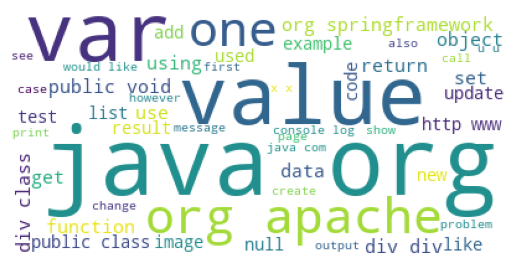

In [54]:
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(raw_tokens_text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

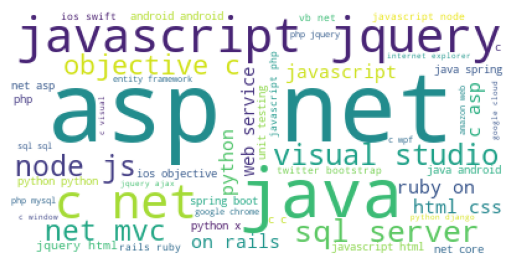

In [55]:
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(raw_tokens_tags))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [56]:
tmp_text= pd.Series(raw_tokens_text).value_counts()
tmp_text[tmp_text > 50]

class         43146
new           40188
file          38885
using         36668
string        34498
              ...  
smartphone       51
.closest         51
vals             51
jks              51
ne               51
Length: 9087, dtype: int64

In [57]:
list_most_freq_words = list((tmp_text[tmp_text > 50]).index)
len(list_most_freq_words)

9087

In [73]:
list_most_freq_words[:60]

['class',
 'new',
 'file',
 'using',
 'string',
 'name',
 'code',
 'error',
 'public',
 '+',
 'get',
 'return',
 'x',
 'data',
 'function',
 'id',
 'value',
 'http',
 'user',
 'like',
 'c',
 'use',
 'div',
 'type',
 'work',
 'var',
 '#',
 'int',
 'true',
 'import',
 'want',
 'e',
 'would',
 'set',
 'android',
 'b',
 'object',
 'app',
 'one',
 'method',
 'application',
 'server',
 'void',
 'null',
 'need',
 'problem',
 'text',
 'image',
 'way',
 'test',
 'version',
 'f',
 'trying',
 'table',
 'n',
 'private',
 'script',
 'line',
 'list',
 'false']

In [84]:
elems_not_to_drop_high_freq = set(list_most_freq_words) & set(list_tags_words)
len(elems_not_to_drop_high_freq)

2828

In [85]:
elems_not_to_drop_high_freq

{'suspend',
 'argv',
 'tensorboard',
 'synchronous',
 'xamarin.forms',
 'xmlhttprequest',
 'pow',
 'zip',
 'pca',
 'fill',
 'friend',
 'xmlwriter',
 'hdfs',
 'report',
 'observable',
 'session',
 'imagedata',
 'flat',
 'graphql',
 'keycode',
 'playback',
 'navbar',
 'nsdate',
 'combobox',
 'blueprint',
 'lambda',
 'chai',
 'httpcontext',
 'redirect',
 'yaml',
 'bluetooth',
 'clause',
 'rack',
 'body-parser',
 'block',
 'nm',
 'evaluation',
 'dropbox',
 'lookup',
 'forum',
 'protection',
 'reader',
 'osc',
 'permutation',
 'storage',
 'transient',
 'refer',
 'gemfile',
 'iostream',
 'iboutlet',
 'taglib',
 'keyup',
 'built-in',
 'z-index',
 'jta',
 'dart',
 'pad',
 'code',
 'mov',
 'support-v',
 'keyvaluepair',
 '.datatable',
 'geometry',
 'uniform',
 'cpu',
 'moq',
 'uiapplication',
 'sam',
 'wsse',
 'region',
 'pack',
 'dimension',
 'system.data',
 'cassandra',
 'applet',
 'ip',
 'logstash',
 'ghc',
 'recording',
 'psycopg',
 'tcpclient',
 'hyperlink',
 'uinavigationcontroller',
 'req

In [ ]:
too_freq_words = [w for w in list_most_freq_words[:800] if w not in elems_not_to_drop_high_freq]
len(too_freq_words)

In [ ]:
too_freq_words_df = pd.DataFrame({"words" : too_freq_words})

In [167]:
too_freq_words_2 = pd.read_csv('data/cleaned/too_freq_words.csv', index=False)
too_freq_words_2

,words
0,new
1,using
2,name
3,error
4,data
5,value
6,like
7,use
8,div
9,work


In [90]:
def process_text_2(doc,
                   rejoin=False,
                   stem_or_lem=2
                 ) :
    """function of text processing

    positional arguments:
    ----------------------
    doc: str : the document (aka a text in str format) to process

    opt arguments:
    ---------------------
    rejoin: bool : if True return a string else return a list of tokens

    return:
    --------------------
    a string (if rejoin is True) or a list of tokens
    """

    #tokenizer
    tokenizer = nltk.RegexpTokenizer(r'[a-zA_\-+#]*\.?[a-zA_\+#]+')
    raw_tokens_list = tokenizer.tokenize(doc)

    #############################################################################################
    # stop words:
    english_stop_words=nltk.corpus.stopwords.words('English')
    cleaned_tokens_list = [word for word in raw_tokens_list if word not in english_stop_words]

    #############################################################################################

    #lemmatizer
    if stem_or_lem == 1:
        trans = SnowballStemmer("english")
        trans_text = [trans.stem(word) for word in cleaned_tokens_list]
    if stem_or_lem == 2:
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(word) for word in cleaned_tokens_list]
    else:
        trans_text = cleaned_tokens_list

    most_freq = [w for w in trans_text if w not in too_freq_words]

    if rejoin:
        return " ".join(most_freq)

    return most_freq

In [91]:
def final_clean_2(doc):
    new_doc = process_text_2(doc,
                           rejoin=True,
                           )
    return new_doc

In [92]:
df

,Title,Body,Tags,_clean_tags,_len_body,Body_2,_len_body_2
0,giving unix process exclusive rw access directory,way sandbox linux process certain directory gi...,linux ubuntu process sandbox selinux,"[linux, ubuntu, process, sandbox, selinux]",526,sandbox linux process certain directory give p...,494
1,automatic repaint minimizing window,jframe two panel one panel draw line working m...,java graphics jframe jpanel paint,"[java, graphics, jframe, jpanel, paint]",2969,jframe two panel panel draw line working minim...,2874
2,man-in-the-middle attack security threat ssh a...,expert network security pardon question smart ...,security ssh ssh-keys openssh man-in-the-middle,"[security, ssh, ssh-keys, openssh, man-in-the-...",447,expert network security pardon question smart ...,447
3,managing data access simple winforms app,simple winforms data entry app us sqlite alway...,c# winforms sqlite datatable sqlconnection,"[c#, winforms, sqlite, datatable, sqlconnection]",2537,simple winforms entry app u sqlite always sing...,2421
4,render basic html view,basic node.js app trying get ground using expr...,javascript html node.js mongodb express,"[javascript, html, node.js, mongodb, express]",335,basic node.js app trying get ground using expr...,320
...,...,...,...,...,...,...,...
49995,bypass vertica error execution time exceeded r...,using ssis tool ole db downloading data vertic...,sql-server ssas oledb sql-server-data-tools ve...,"[sql-server, ssas, oledb, sql-server-data-tool...",206,using ssis tool ole db downloading vertica dat...,196
49996,conflicting conditional operation currently pr...,using f uploading file already created bucket ...,python amazon-web-services amazon-s boto pytho...,"[python, amazon-web-services, amazon-s, boto, ...",301,using f uploading file already created bucket ...,284
49997,problem lr_find pytorch fastai course,following jupyter notebook course hit upon err...,python machine-learning deep-learning pytorch ...,"[python, machine-learning, deep-learning, pyto...",908,following jupyter notebook course hit upon lin...,831
49998,jsonpatch escape slash jsonpatch+json,json wanted update field process my-process po...,java json rest json-patch http-patch,"[java, json, rest, json-patch, http-patch]",645,json wanted update field process my-process po...,606


In [93]:
df['Body_2'] = df['Body'].parallel_apply(lambda x : final_clean_2(x))

In [168]:
df['Title_2'] = df['Title_2'].parallel_apply(lambda x : final_clean_2(x))

In [101]:
df.to_csv("data/cleaned/df_process_text_3.csv", index=False)